# Comparative Analysis of Tool-less Agents

This notebook compares the performance of different language models in a tool-less agentic setting:
- **GPT-5-nano** (analyzed in `1.1.1.run_toolless_gpt5nano_agent.ipynb`)
- **Llama-3.1-8B-Instruct** (analyzed in `1.1.2.run_toolless_llama318b_agent.ipynb`)

All agents predict IC50 values for the `HUCCT1_BILIARY_TRACT` cell line across 100 drugs from the DepMap PRISM dataset. This notebook consolidates their logged predictions to:
- Compare fold error and absolute error distributions
- Examine the relationship between model confidence and prediction accuracy
- Visualize performance differences across model architectures

In [1]:
from pathlib import Path
import re
import json

import matplotlib.pyplot as plt

from dspy_litl_agentic_system.metrics import absolute_error, fold_error
from nbutils.pathing import repo_root
from nbutils.utils import IN_NOTEBOOK

if IN_NOTEBOOK:
    print("Running in IPython shell")
else:
    print("Running in standard Python shell")

Running in IPython shell


## Same parameters as the demo

In [2]:
N = 100
CCLE_NAME = "HUCCT1_BILIARY_TRACT"
SHUFFLE_QUEUE = True
SHUFFLE_SEED = 42

## Read all the demo logs

In [3]:
git_root = repo_root()

log_path = Path(git_root) \
    / "analysis" / "log" / "demo" / "toolless" / CCLE_NAME

if not log_path.exists():
    raise FileNotFoundError(f"Log path {log_path} does not exist")

log_dict = {}
for file in log_path.glob("*.jsonl"):
    match = re.search(r"model=([^;]+);.*temperature=([^;]+);", file.name)
    if match:
        model_name = match.group(1)
        temperature = match.group(2)
        key = f"{model_name}_temp_{temperature}"
        with file.open("r") as f:
            log_dict[key] = [json.loads(line) for line in f]

## Compute fold and absolute errors

In [4]:
error_results = {}

for model_key in log_dict:
    ic50_true = [trace_unit['ic50_true'] for trace_unit in log_dict[model_key]]
    ic50_pred = [trace_unit['ic50_pred'] for trace_unit in log_dict[model_key]]
    confidence = [trace_unit['confidence'] for trace_unit in log_dict[model_key]]
    
    fold_err = fold_error(ic50_true, ic50_pred, epsilon=1e-10)
    abs_err = absolute_error(ic50_true, ic50_pred)
    
    error_results[model_key] = {
        'fold_error': fold_err,
        'absolute_error': abs_err,
        'confidence': confidence,
    }

### Compute fold error and plot

As anticipated, our agents, without any external tools and memory, does not display improved predictive performance iterating over the task queue. 

There seemed to be a weak negative correlation between confidence and error evidence from the absolute error vs confidence plot of the GPT5-nano agent. 
Interestingly, the Llama agent produced modes of confidence scores at 80 and 85.

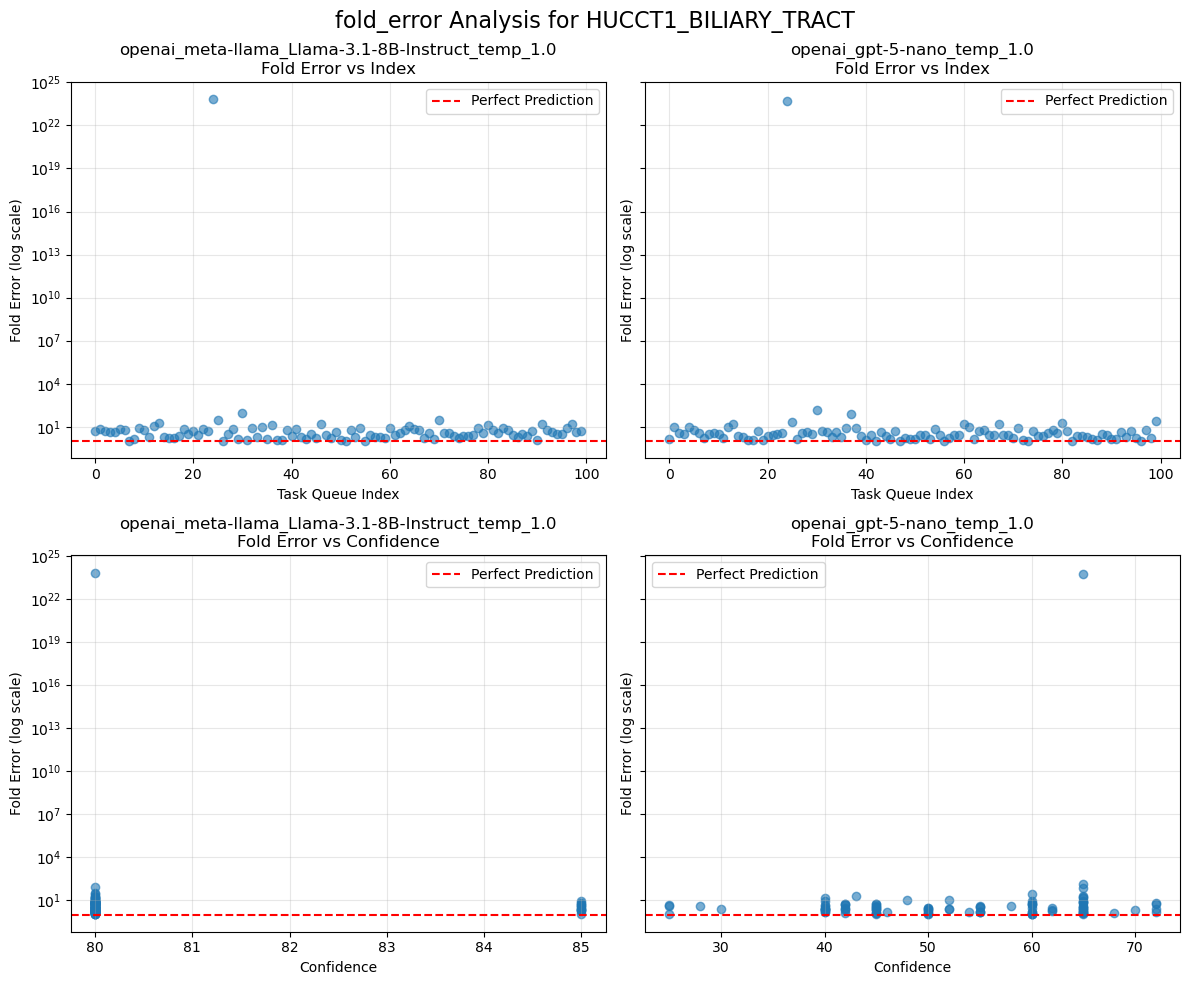

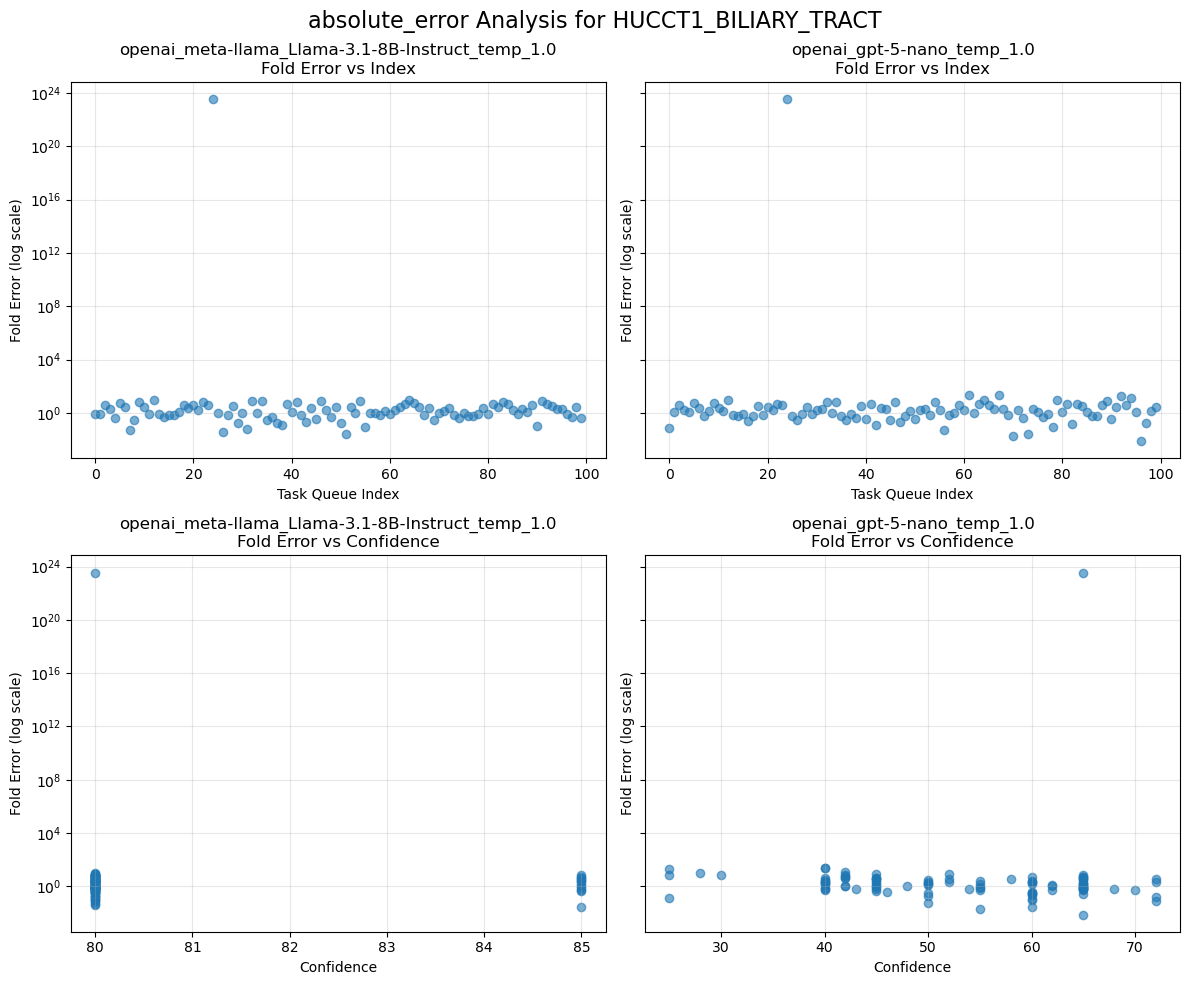

In [5]:
n_models = len(error_results)

for error_type, perfect_score, use_log in [
    ('fold_error', 1, True), 
    ('absolute_error', None, True)
]:

    fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10), sharey='row')
    if n_models == 1:
        axes = axes.reshape(-1, 1)

    for col_idx, model_key in enumerate(error_results):
        
        err = error_results[model_key][error_type]
        confidence = error_results[model_key]['confidence']
        
        # First row: error vs index
        ax1 = axes[0, col_idx]
        ax1.scatter(range(len(err)), err, alpha=0.6)
        ax1.set_yscale('log' if use_log else 'linear')
        ax1.set_xlabel('Task Queue Index')
        ax1.set_ylabel('Fold Error (log scale)')
        ax1.set_title(f'{model_key}\nFold Error vs Index')
        ax1.grid(True, alpha=0.3)
        
        # Second row: error vs confidence
        ax2 = axes[1, col_idx]
        ax2.scatter(confidence, err, alpha=0.6)
        ax2.set_yscale('log' if use_log else 'linear')
        ax2.set_xlabel('Confidence')
        ax2.set_ylabel('Fold Error (log scale)')
        ax2.set_title(f'{model_key}\nFold Error vs Confidence')
        ax2.grid(True, alpha=0.3)

        if perfect_score is not None:
            for _ax in [ax1, ax2]:
                _ax.axhline(
                    y=perfect_score, 
                    color='red', 
                    linestyle='--', 
                    label='Perfect Prediction', 
                    zorder=2
                )
                _ax.legend()

    fig.suptitle(f'{error_type} Analysis for {CCLE_NAME}', fontsize=16)
    plt.tight_layout()
    
    if IN_NOTEBOOK:
        plt.show()
    else:
        print("Not in a notebook environment. Skipping plot display")

    out_dir = repo_root() / "output" / "figures" / "demo" 
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{error_type}.png"
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)